# EMNIST OCR (v5.0 - Center of Mass)

**Version 5.0 Updates:**
- **Center of Mass (CoM)**: Implements the "Gold Standard" EMNIST preprocessing.
- **Fixes Distortion**: Prevents thin letters (I, l, 1) from being stretched wide.
- **Retained Features**: Data Augmentation (v4) and 'byclass' split.

### Why CoM?
EMNIST images aren't just resized to fit the box. They are placed so their "weight" (ink density) is exactly in the middle. This notebook replicates that math.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from emnist import extract_training_samples, extract_test_samples
import numpy as np

def train_and_save_emnist():
    print("Veri seti indiriliyor ve yükleniyor...")
    
    # 'balanced' seti: Rakamlar ve Harfler karışık (47 sınıf)
    # EMNIST resimleri genelde yan dönük gelir, transpose ile düzeltiyoruz.
    train_images, train_labels = extract_training_samples('balanced')
    test_images, test_labels = extract_test_samples('balanced')

    # Normalizasyon (0-1 arası)
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # Boyut Ayarlama (28x28x1)
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

    print(f"Eğitim verisi boyutu: {train_images.shape}")
    print(f"Sınıf sayısı (Label): {len(np.unique(train_labels))}")

    # CNN Modelini Oluştur (Çıktı katmanı 47 nöron olacak)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Aşırı öğrenmeyi engellemek için
        layers.Dense(47, activation='softmax') # 47 Sınıf (0-9 ve A-Z)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print("Model eğitiliyor...")
    model.fit(train_images, train_labels, epochs=200, batch_size=64, validation_split=0.1)

    model.save('emnist_model.h5')
    print("Harf ve Rakam tanıyan model 'emnist_model.h5' olarak kaydedildi!")

if __name__ == "__main__":
    train_and_save_emnist()

Veri seti indiriliyor ve yükleniyor...
Eğitim verisi boyutu: (112800, 28, 28, 1)
Sınıf sayısı (Label): 47
Model eğitiliyor...
Epoch 1/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6457 - loss: 1.1827 - val_accuracy: 0.8167 - val_loss: 0.5293
Epoch 2/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7774 - loss: 0.6851 - val_accuracy: 0.8471 - val_loss: 0.4304
Epoch 3/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8068 - loss: 0.5884 - val_accuracy: 0.8607 - val_loss: 0.3912
Epoch 4/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8245 - loss: 0.5260 - val_accuracy: 0.8583 - val_loss: 0.3892
Epoch 5/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8333 - loss: 0.4897 - val_accuracy: 0.8690 - val_loss: 0.3630
Epoch 6/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8434 - loss: 0.4580 - val_accuracy: 0.8651 - val_loss: 0.3667
Epoch 7/200
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8498 - loss:

Harf ve Rakam tanıyan model 'emnist_model.h5' olarak kaydedildi!


## 1. Load Data

In [2]:
print("Loading EMNIST (ByClass)...")
X_train_raw, y_train = extract_training_samples('byclass')
X_test_raw, y_test = extract_test_samples('byclass')

# TRANSPOSE
X_train = np.array([img.T for img in X_train_raw])
X_test = np.array([img.T for img in X_test_raw])

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

num_classes = 62
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

emnist_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

Loading EMNIST (ByClass)...


## 2. Model Training (with Augmentation)

In [3]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

model_path = 'emnist_v5_com.h5'

print("Starting Training (10 Epochs)...")
history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=512),
                    epochs=10,
                    validation_data=(X_test, y_test_cat),
                    verbose=1)

model.save(model_path)
print("Model Saved.")

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Training (10 Epochs)...
Epoch 1/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 194s 141ms/step - accuracy: 0.6477 - loss: 1.2247 - val_accuracy: 0.8246 - val_loss: 0.5022
Epoch 2/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 185s 136ms/step - accuracy: 0.7524 - loss: 0.7824 - val_accuracy: 0.8362 - val_loss: 0.4529
Epoch 3/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 184s 135ms/step - accuracy: 0.7749 - loss: 0.6960 - val_accuracy: 0.8437 - val_loss: 0.4301
Epoch 4/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 184s 135ms/step - accuracy: 0.7869 - loss: 0.6518 - val_accuracy: 0.8472 - val_loss: 0.4212
Epoch 5/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 184s 135ms/step - accuracy: 0.7941 - loss: 0.6250 - val_accuracy: 0.8481 - val_loss: 0.4161
Epoch 6/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 184s 135ms/step - accuracy: 0.7992 - loss: 0.6065 - val_accuracy: 0.8488 - val_loss: 0.4190
Epoch 7/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 184s 135ms/step - accuracy: 0.8040 - loss: 0.5915 - val_accuracy: 0.8531 - val_loss: 0.4061
Epoch 8/10
1364/1364 ━━━━━━━━

Model Saved.


## 3. Center of Mass Preprocessing (THE FIX)


Checking: segmented_Amoxicillin1000mg
  Result: Ct0FrnMtrnIIBDGO

Checking: segmented_Cipro500mg
  Result: nNSaeN0D4U

Checking: segmented_coaxil125mg
  Result: CGnLttttCNEw

Checking: segmented_depakine500mg
  Result: OMISThtSMeOOENr

Checking: segmented_insulin100iu
  Result: IEN3tCt50CD

Checking: segmented_lantus100ml
  Result: IaCtJNtC0Ftt

Checking: segmented_levozin5mg
  Result: r0T04tCrFe

Checking: segmented_norvasc5mg
  Result: IOataNnrFO

Checking: segmented_tramadol50mg
  Result: taCEtOOtN05D

Checking: segmented_xarelto15mg
  Result: tQratt0tNFeI

--- RECEIPTS ---
Receipt: Amoxicillin1000mg.jpg


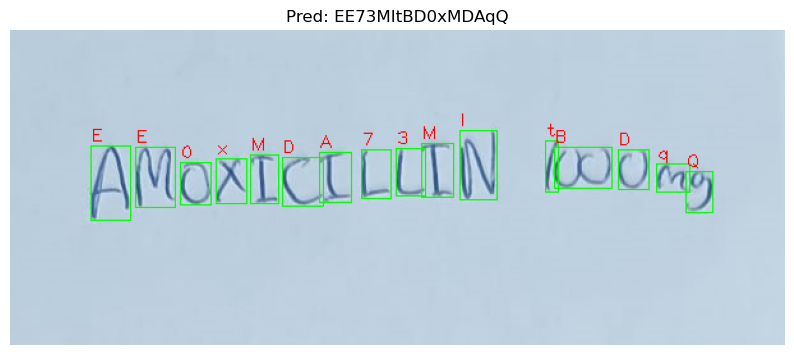

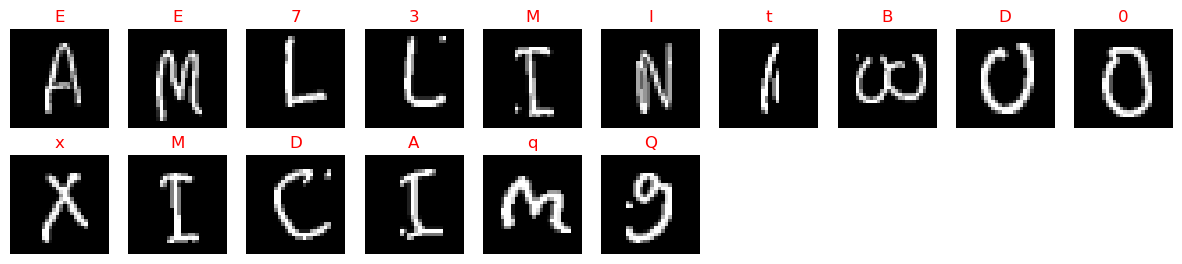

  Text: EE73MItBD0xMDAqQ
------------------------------
Receipt: Cipro500mg.jpg


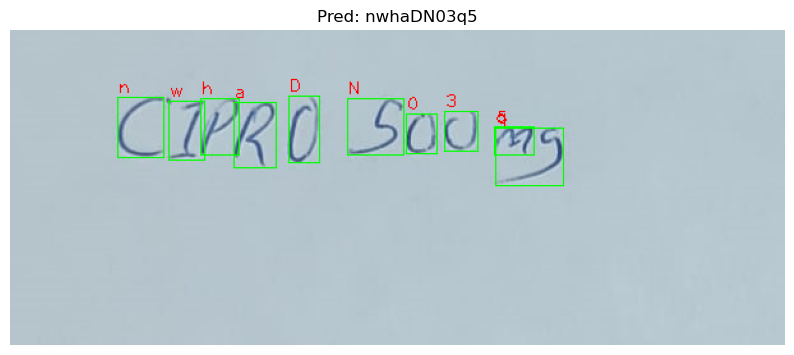

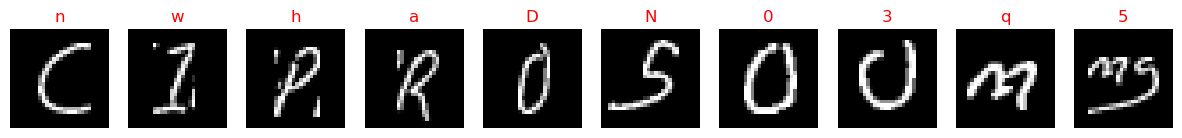

  Text: nwhaDN03q5
------------------------------
Receipt: coaxil125mg.jpg


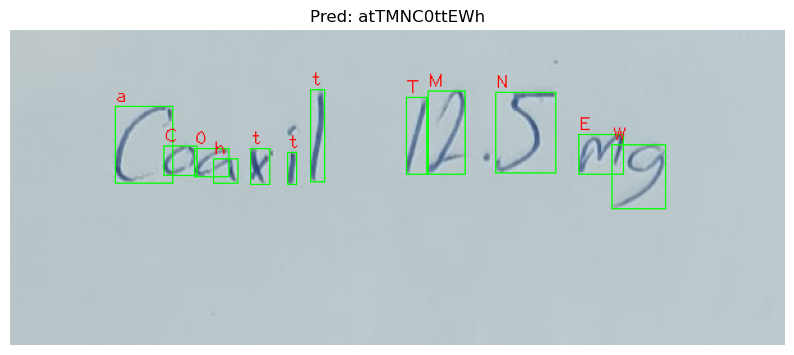

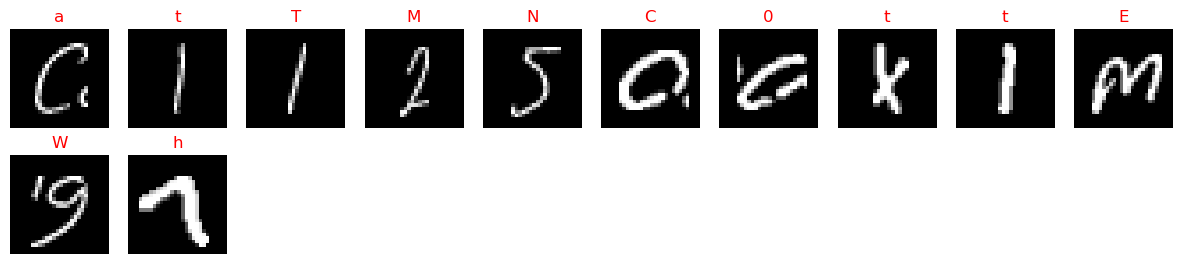

  Text: atTMNC0ttEWh
------------------------------
Receipt: depakine500mg.jpg


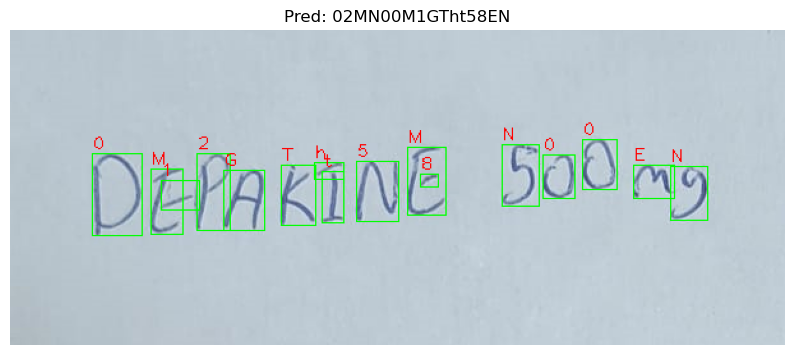

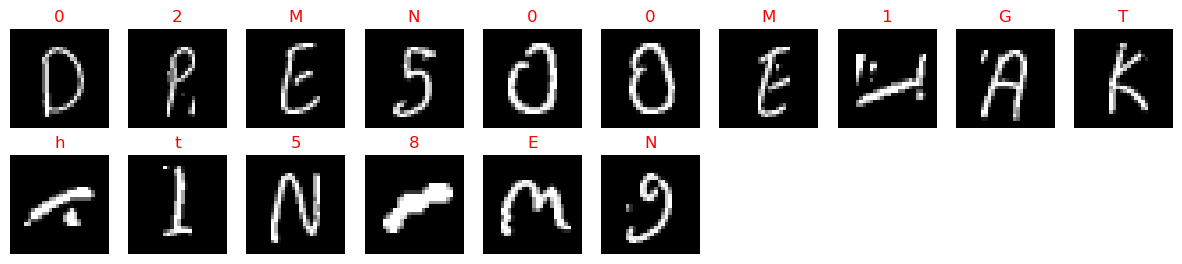

  Text: 02MN00M1GTht58EN
------------------------------
Receipt: insulin100iu.jpg


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4211: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'


In [5]:
def get_best_shift(img):
    cy, cx = center_of_mass(img)
    rows, cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)
    return shiftx, shifty

def shift(img, sx, sy):
    rows, cols = img.shape
    M = np.float32([[1, 0, sx], [0, 1, sy]])
    shifted = cv2.warpAffine(img, M, (cols, rows))
    return shifted

def preprocess_character_v5(image, target_size=28):
    # 1. Resize to 20x20 while preserving aspect ratio
    # Note: We fit to 20x20 box inside 28x28, leaving 4px padding
    h, w = image.shape
    if h == 0 or w == 0: return None
    
    # Fit to 20x20 box
    scale = 20.0 / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # 2. Place in center of 28x28 canvas
    canvas = np.zeros((28, 28), dtype='uint8')
    y_off = (28 - new_h) // 2
    x_off = (28 - new_w) // 2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized
    
    # 3. Center by Mass
    # We shift the image so the ink center is at the geometric center
    shiftx, shifty = get_best_shift(canvas)
    shifted = shift(canvas, shiftx, shifty)
    
    return shifted.astype('float32') / 255.0

def sort_regions(regions):
    regions = sorted(regions, key=lambda r: r.bbox[0])
    if not regions: return []
    lines = []
    current_line = [regions[0]]
    current_y = regions[0].bbox[0]
    for r in regions[1:]:
        if r.bbox[0] > current_y + 15:
            current_line.sort(key=lambda x: x.bbox[1])
            lines.extend(current_line)
            current_line = [r]
            current_y = r.bbox[0]
        else:
            current_line.append(r)
    current_line.sort(key=lambda x: x.bbox[1])
    lines.extend(current_line)
    return lines

def predict_text_v5(image_path, show_debug=False):
    if not os.path.exists(image_path): return "File missing"
    img = cv2.imread(image_path)
    if img is None: return "Read Error"
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    cleaned = cv2.medianBlur(binary, 3)
    
    lbl = label(cleaned)
    regions = regionprops(lbl)
    valid_regions = []
    img_area = gray.shape[0] * gray.shape[1]
    for r in regions:
        if r.area > 50 and r.area < (img_area * 0.2):
            valid_regions.append(r)
            
    sorted_regions = sort_regions(valid_regions)
    
    pred_str = ""
    annotated = img.copy()
    debug_images = []
    
    for r in sorted_regions:
        minr, minc, maxr, maxc = r.bbox
        char_crop = cleaned[minr:maxr, minc:maxc]
        
        # USE V5 PREPROCESSING
        nn_input = preprocess_character_v5(char_crop)
        if nn_input is None: continue
        
        nn_batch = np.expand_dims(np.expand_dims(nn_input, -1), 0)
        pred = model.predict(nn_batch, verbose=0)
        char = emnist_map[np.argmax(pred)]
        
        pred_str += char
        debug_images.append((char, nn_input))
        cv2.rectangle(annotated, (minc, minr), (maxc, maxr), (0, 255, 0), 1)
        cv2.putText(annotated, char, (minc, minr-3), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)

    if show_debug:
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {pred_str}")
        plt.axis('off')
        plt.show()
        
        if len(debug_images) > 0:
             # Show debug
             cols = 10
             rows = (len(debug_images) // cols) + 1
             plt.figure(figsize=(15, rows * 1.5))
             for i, (c, img_in) in enumerate(debug_images):
                 plt.subplot(rows, cols, i+1)
                 plt.imshow(img_in, cmap='gray')
                 plt.title(f"{c}", color='red')
                 plt.axis('off')
             plt.show()

    return pred_str

# -------------------------
# DIAGNOSE ALL
# -------------------------
base_path = "all-segmented-outputs"
if os.path.exists(base_path):
    subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for sd in subdirs:
        print(f"\nChecking: {sd}")
        files = sorted(glob.glob(os.path.join(base_path, sd, "*.png")) + glob.glob(os.path.join(base_path, sd, "*.jpg")))
        res = ""
        for f in files:
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            # Use V5
            inp = preprocess_character_v5(img)
            batch = np.expand_dims(np.expand_dims(inp, -1), 0)
            res += emnist_map[np.argmax(model.predict(batch, verbose=0))]
        print(f"  Result: {res}")

# Check Receipts
print("\n--- RECEIPTS ---")
rec_files = glob.glob(os.path.join("handwritten-receipts", "*.jpg"))
for f in rec_files:
    print(f"Receipt: {os.path.basename(f)}")
    print(f"  Text: {predict_text_v5(f, show_debug=True)}")
    print("-"*30)